In [1]:
import sys
from pathlib import Path
notebook_dir = Path('/home/chan21/idiosyncratic-neural-geometry/notebooks')
while not (notebook_dir / 'src').exists():
    notebook_dir = notebook_dir.parent
    
if str(notebook_dir) not in sys.path:
    sys.path.append(str(notebook_dir))

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from pathlib import Path
from src.utils._config import *
from src.utils._io import *
from src.utils._paths import *
from src.spectra._definition import *
from src.utils.plot import *
import argparse
from tqdm import tqdm
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

HOME_DIR = Path("/data/chan21/idiosyncratic-neural-geometry")


DEFAULT = {
    "figure.facecolor": "None",
    "axes.facecolor": "None",
    "axes.spines.top": False,
    "axes.spines.right": False,
    "xtick.minor.visible": False,
    "ytick.minor.visible": False,
    "patch.linewidth": 0,
    "xtick.minor.size": 0,
    "ytick.minor.size": 0,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "axes.labelsize": 32, 
}

sns.set_theme(style="ticks", rc=DEFAULT)

Configure spectra

In [2]:
movies = ['iteration', 'defeat', 'growth', 'lemonade']
rois = ['occipital', 'ventral', 'temporal', 'dmn']
rois_names = {'occipital': 'early',
              'ventral': 'ventral',
              'temporal': 'lateral',
              'dmn': 'parietal-cingulate'
              }
metric = 'cov'
color="magma"
roi_colors = sns.color_palette(color, len(rois))

Load spectra

In [3]:
# Observed spectra
roi_spectra = {
    roi: {} for roi in rois
}
for i, roi in enumerate(rois):
    eigenspectra_path = Path("/data/chan21/idiosyncratic-neural-geometry/results/") / f"{metric}_{roi}_functional_perm" / "eigenspectra.h5" 
    with h5py.File(eigenspectra_path, 'r') as f:
        h5 = f['data']
        for key in h5.keys():
            roi_spectra[roi][key] = h5[key]['observed'][:]

min_length = 1000
indices=np.arange(1, min_length) 
bin_assignments = [assign_data_to_geometrically_spaced_bins(
    index + 1,
    density=3,
    start=1,
    stop=10_000) for index in indices]
unique_bins = np.unique(bin_assignments)

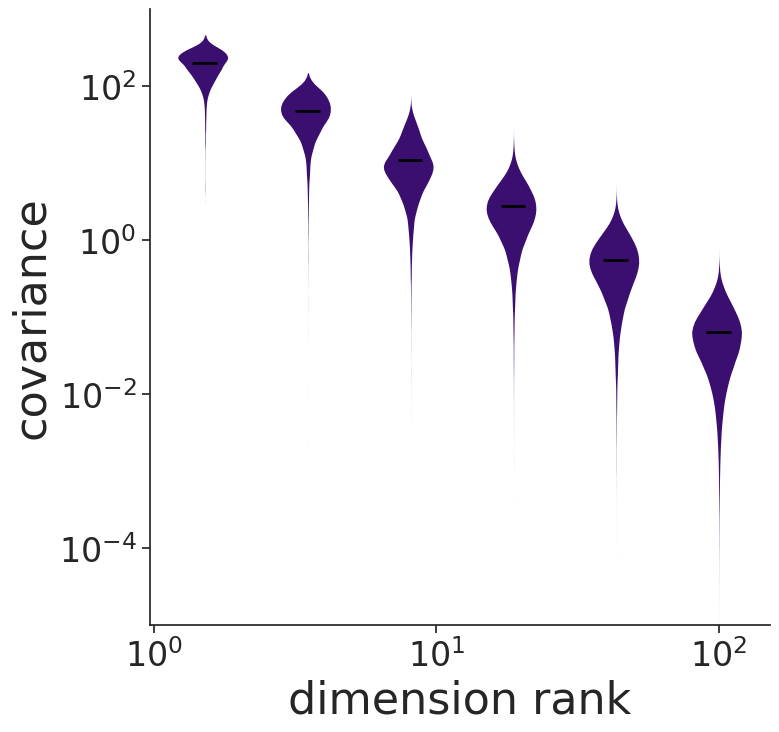

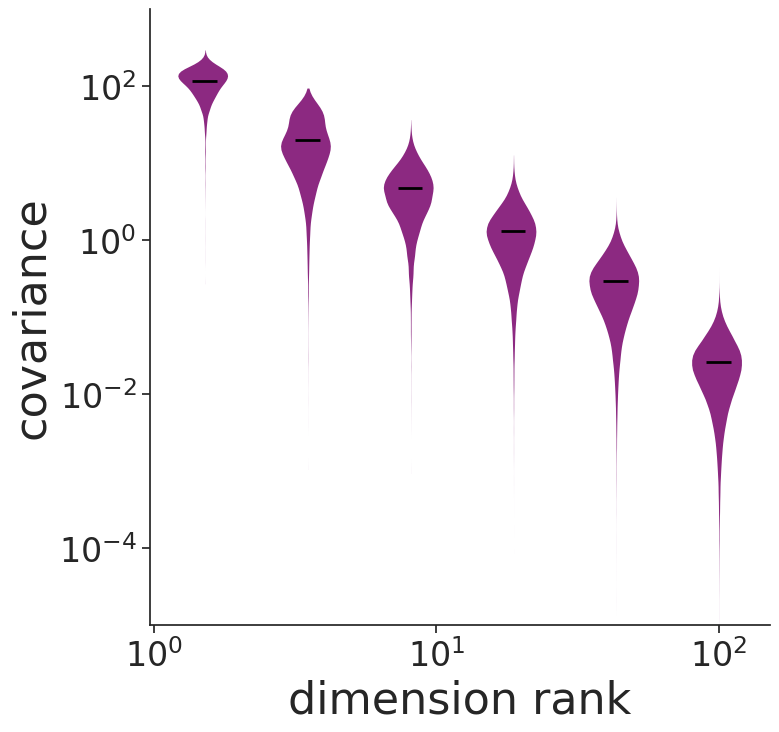

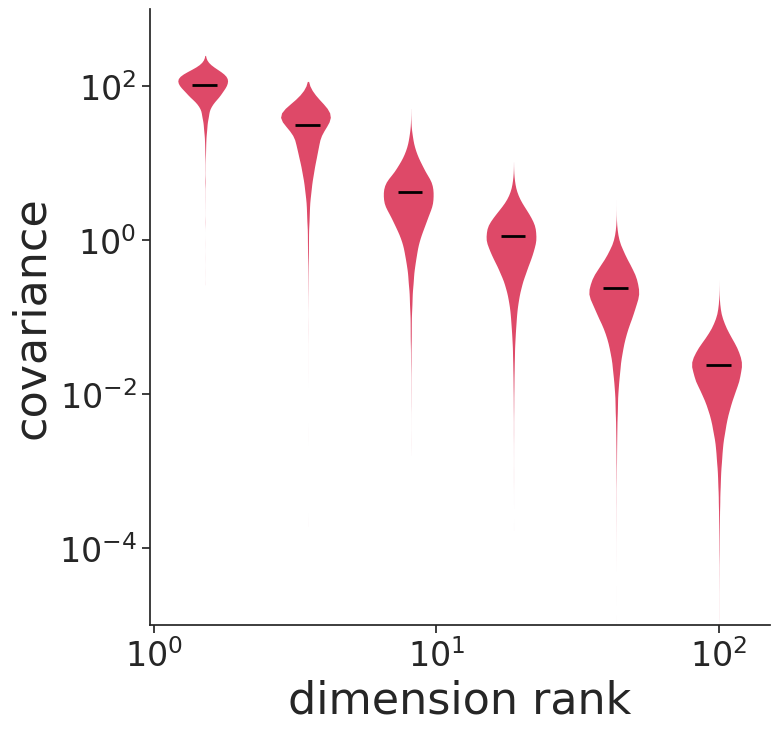

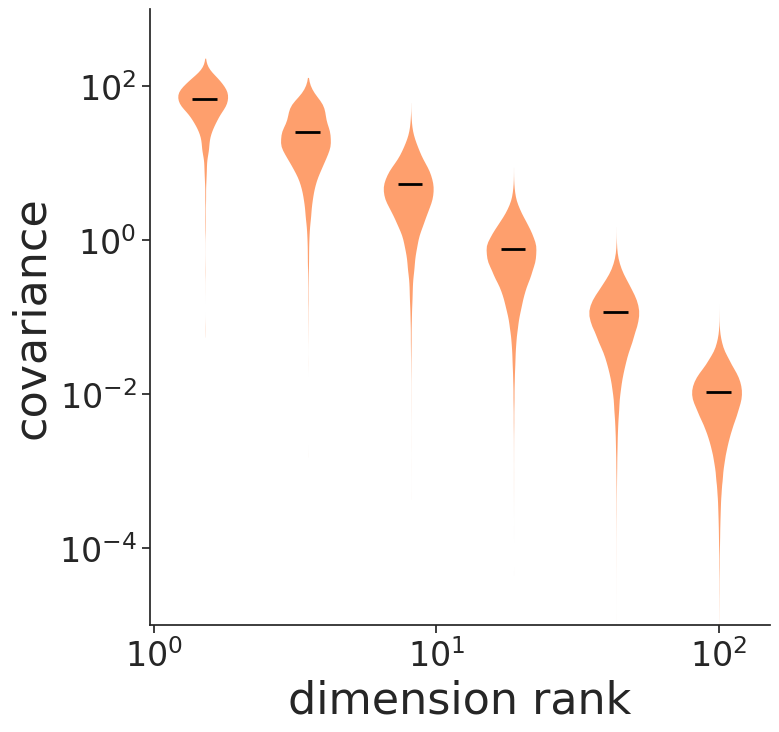

In [4]:
import json

for roi in rois:
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    # Collect data
    all_binned_spectrum = {bin: [] for bin in unique_bins}
    for key in roi_spectra[roi].keys():
        spectrum = roi_spectra[roi][key]
        for bin, value in zip(bin_assignments, spectrum):
            all_binned_spectrum[bin].append(value)
    all_binned_values = [np.array(all_binned_spectrum[bin]) for bin in unique_bins]

    # Plot violins
    for idx, (pos, data) in enumerate(zip(unique_bins[:6], all_binned_values[:6])):
        original_data = data.copy()  # Keep original data including negatives
        data_positive = data[data > 0]  # Remove zeros or negative values for violin plot
        
        if len(data_positive) > 0:
            # Calculate the true mean from all data (including negatives)
            true_mean = np.mean(original_data)
            positive_mean = np.mean(data_positive)
            
            # Calculate shift needed to align with true mean
            shift = np.log10(true_mean) - np.log10(positive_mean) if positive_mean > 0 else 0
            
            # Calculate KDE in log space
            log_data = np.log10(data_positive)
            kernel = stats.gaussian_kde(log_data)
            
            # Use exact data range
            log_min, log_max = log_data.min(), log_data.max()
            log_space = np.linspace(log_min, log_max, 100)
            density = kernel(log_space)
            
            # Apply shift and convert back to linear space
            log_space = log_space + shift
            x = np.power(10, log_space)
            
            # Plot violin
            width = 0.2 * pos
            scaled_density = density / density.max() * width

            ax.fill_betweenx(x, pos - scaled_density, pos + scaled_density, 
                            alpha=1, color=roi_colors[rois.index(roi)])
            # Add mean line using true mean
            ax.hlines(true_mean, pos - width/2, pos + width/2, color='black', linewidth=2)
        

    # Set scales and limits
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(1e-5, 1e3) if metric == 'cov' else ax.set_ylim(1e-3, 1e0)
    ax.set_yticks([10**-4, 10**-2, 10**0, 10**2])

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xlabel('dimension rank')
    ax.set_ylabel('covariance' if metric == 'cov' else 'correlation')

    # save as svg
    #plt.savefig(f'/home/chan21/idiosyncratic-neural-geometry/notebooks/figures/figure1_{roi}.pdf', dpi=300, bbox_inches='tight')
    #plt.savefig(f'/home/chan21/idiosyncratic-neural-geometry/notebooks/figures/figure1_{roi}.svg', dpi=300, bbox_inches='tight')
    plt.show()
    